In [1]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
import random

Segmentation Models: using `keras` framework.


In [2]:
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

'tf.keras'

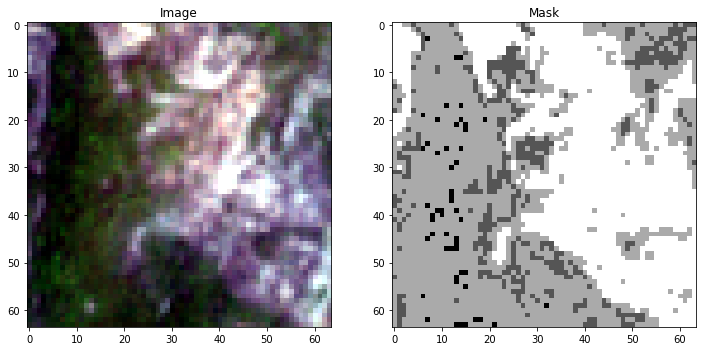

In [5]:
# train_img_dir = "../input/kerasv4/data_for_keras_aug/train_images/train/"
# train_mask_dir = "../input/kerasv4/data_for_keras_aug/train_masks/train/"

train_img_dir = "/home/shrayank_mistry/Modules/data/kaggle_data/train_images/train/"
train_mask_dir = "/home/shrayank_mistry/Modules/data/kaggle_data/train_masks/train/"

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_img_dir))

img_list.sort()
msk_list.sort()
img_num = random.randint(0, num_images-1)

img_for_plot = cv2.imread(train_img_dir+img_list[img_num], 1)
img_for_plot = cv2.cvtColor(img_for_plot, cv2.COLOR_BGR2RGB)

mask_for_plot =cv2.imread(train_mask_dir+msk_list[img_num], 0)

plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(img_for_plot)
plt.title('Image')
plt.subplot(122)
plt.imshow(mask_for_plot, cmap='gray')
plt.title('Mask')
plt.show()

In [28]:
# mask_for_plot = mask_for_plot - 1
# mask_for_plot

In [89]:
seed = 24
batch_size = 32
n_classes = 4

In [30]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from tensorflow.keras.utils import to_categorical

In [31]:
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [90]:
def preprocess_data(img, mask, num_class):
    #Scale images
    img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
    img = preprocess_input(img)  #Preprocess based on the pretrained backbone...
    #Convert mask to one-hot
    mask = mask - 1
    mask = to_categorical(mask, num_class)
      
    return (img,mask)

In [91]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def trainGenerator(train_img_path, train_mask_path, num_class):
    
    img_data_gen_args = dict(horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect')
    
    image_datagen = ImageDataGenerator(**img_data_gen_args)
    mask_datagen = ImageDataGenerator(**img_data_gen_args)
    
    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    
    mask_generator = mask_datagen.flow_from_directory(
        train_mask_path,
        class_mode = None,
        color_mode = 'grayscale',
        batch_size = batch_size,
        seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    
    for (img, mask) in train_generator:
        img, mask = preprocess_data(img, mask, num_class)
        yield (img, mask)

In [34]:
train_img_path = "/home/shrayank_mistry/Modules/kaggle_data/data_for_keras_aug/train_images/"
train_mask_path = "/home/shrayank_mistry/Modules/kaggle_data/data_for_keras_aug/train_masks/"
train_img_gen = trainGenerator(train_img_path, train_mask_path, num_class=4)

val_img_path = "/home/shrayank_mistry/Modules/kaggle_data/data_for_keras_aug/val_images/"
val_mask_path = "/home/shrayank_mistry/Modules//kaggle_data/data_for_keras_aug/val_masks/"
val_img_gen = trainGenerator(val_img_path, val_mask_path, num_class=4)

In [35]:
x, y = train_img_gen.__next__()

Found 14985 images belonging to 1 classes.
Found 14985 images belonging to 1 classes.


In [36]:
print(x.shape, y.shape)

(16, 256, 256, 3) (16, 256, 256, 4)


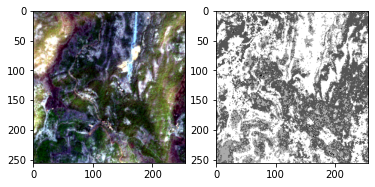

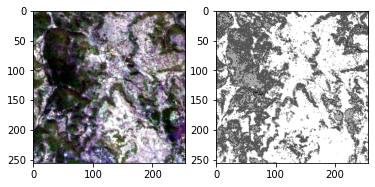

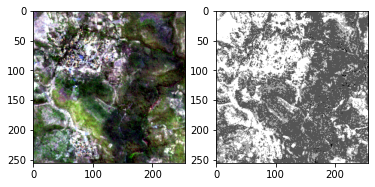

In [37]:
for i in range(0,3):
    image = x[i]
    mask = np.argmax(y[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.show()

In [38]:
x_val, y_val = val_img_gen.__next__()

Found 14985 images belonging to 1 classes.
Found 14985 images belonging to 1 classes.


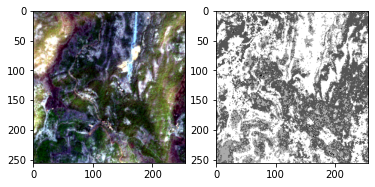

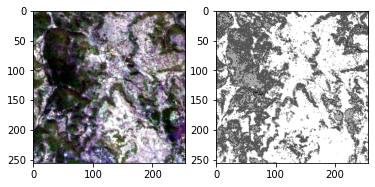

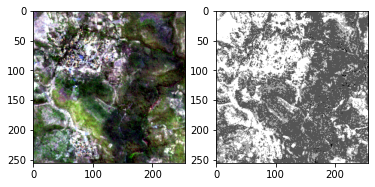

In [39]:
for i in range(0,3):
    image = x_val[i]
    mask = np.argmax(y_val[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.show()

In [40]:
num_train_imgs = len(os.listdir('/home/shrayank_mistry/Modules/kaggle_data/data_for_keras_aug/train_images/train/'))
num_val_images = len(os.listdir('/home/shrayank_mistry/Modules/kaggle_data/data_for_keras_aug/val_images/val/'))
steps_per_epoch = num_train_imgs//batch_size
val_steps_per_epoch = num_val_images//batch_size

In [41]:
print(num_train_imgs, num_val_images)

14985 14985


In [42]:
IMG_HEIGHT = x.shape[1]
IMG_WIDTH  = x.shape[2]
IMG_CHANNELS = x.shape[3]

n_classes=4

In [43]:
model = sm.Unet(BACKBONE, encoder_weights='imagenet', 
                input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
                classes=n_classes, activation='softmax')
model.compile('Adam', loss=sm.losses.categorical_focal_jaccard_loss, metrics=[sm.metrics.iou_score])

In [44]:
print(model.summary())
print(model.input_shape)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 256, 256, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_34 (ZeroPadding2 (None, 262, 262, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 128, 128, 64) 9408        zero_padding2d_34[0][0]          
____________________________________________________________________________________________

In [45]:
history=model.fit(train_img_gen,
          steps_per_epoch=steps_per_epoch,
          epochs=25,
          verbose=1,
          validation_data=val_img_gen,
          validation_steps=val_steps_per_epoch)

Epoch 1/25
936/936 [==============================] - 7096s 8s/step - loss: 0.4742 - iou_score: 0.5612 - val_loss: 0.6442 - val_iou_score: 0.3962
Epoch 2/25
936/936 [==============================] - 7079s 8s/step - loss: 0.4178 - iou_score: 0.6157 - val_loss: 0.3828 - val_iou_score: 0.6443
Epoch 3/25
936/936 [==============================] - 7071s 8s/step - loss: 0.3855 - iou_score: 0.6453 - val_loss: 0.4963 - val_iou_score: 0.5591
Epoch 4/25
936/936 [==============================] - 7075s 8s/step - loss: 0.3733 - iou_score: 0.6571 - val_loss: 0.4006 - val_iou_score: 0.6392
Epoch 5/25
936/936 [==============================] - 7065s 8s/step - loss: 0.3661 - iou_score: 0.6640 - val_loss: 0.3807 - val_iou_score: 0.6497
Epoch 6/25
936/936 [==============================] - 7062s 8s/step - loss: 0.3699 - iou_score: 0.6601 - val_loss: 0.3669 - val_iou_score: 0.6622
Epoch 7/25
936/936 [==============================] - 7077s 8s/step - loss: 0.3518 - iou_score: 0.6767 - val_loss: 0.4192 - 

In [46]:
model.save('landcover_25_epochs_RESNET_backbone_batch16.hdf5')

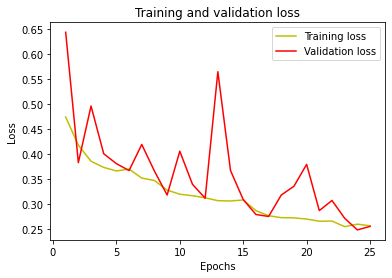

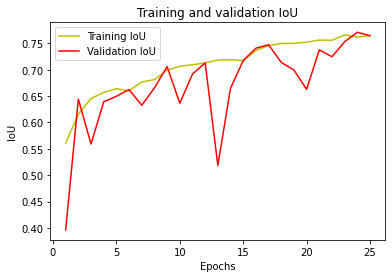

In [47]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [93]:
from keras.models import load_model

model = load_model("landcover_25_epochs_RESNET_backbone_batch16.hdf5", compile=False)

# batch_size=4 #Check IoU for a batch of images

#Test generator using validation data.

test_image_batch, test_mask_batch = val_img_gen.__next__()

#Convert categorical to integer for visualization and IoU calculation
test_mask_batch_argmax = np.argmax(test_mask_batch, axis=3) 
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=3)


StopIteration: 

In [ ]:
test_image_batch.shape

(16, 256, 256, 3)

Mean IoU = 0.813786


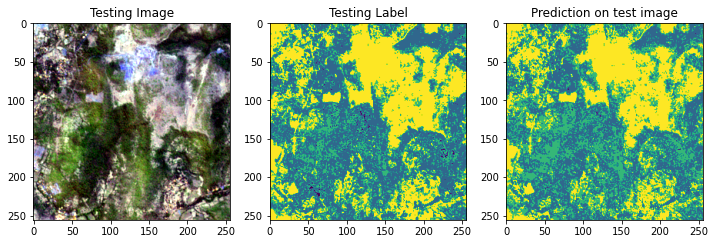

In [63]:
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

#######################################################
#View a few images, masks and corresponding predictions. 
img_num = random.randint(0, test_image_batch.shape[0]-1)

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_image_batch[img_num])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_batch_argmax[img_num])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_pred_batch_argmax[img_num])
plt.show()